In [1]:
import haiku as hk
import jax
from jax import random
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import optax
from sklearn import datasets


from gabenet.layers import CapLayer, PoissonLayer, Sequential
from gabenet.nets import PoissonGammaBelieve

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X_train = digits.images.reshape((n_samples, -1))
m_samples, n_features = X_train.shape

key_seq = hk.PRNGSequence(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [295]:
def build_model():
    return Sequential(layers=[
        CapLayer(input_size=10, frozen=['r', 'c', 'theta']),
        PoissonLayer(input_size=10, output_size=n_features, frozen=['phi'])
    ])

@hk.transform_with_state
def init_model():
    m_samples = len(X_train)
    model = build_model()
    model.forward(m_samples)

@hk.without_apply_rng
@hk.transform_with_state
def _loss_fn(X_train):
    model = build_model()
    return -model.log_likelihood(X_train)

@jax.jit
def loss_fn(params, state, X_train):
    return _loss_fn.apply(params, state, X_train)[0]

dloss_dx = jax.jit(jax.grad(loss_fn))

In [296]:
def max_tree(tree):
    tree_max = jax.tree_util.tree_map(lambda x: jnp.max(x), tree)
    leaves = jax.tree_util.tree_leaves(tree_max)
    return max(leaves)

def min_tree(tree):
    tree_max = jax.tree_util.tree_map(lambda x: jnp.min(x), tree)
    leaves = jax.tree_util.tree_leaves(tree_max)
    return min(leaves)

In [297]:
params, state = init_model.init(next(key_seq))
params = jax.tree_util.tree_map(lambda x: jnp.where(x < 1e-8, 1e-8, x), params)

In [319]:
# learning_rate = 1e-1
learning_rate = 1e-4

lloptimizer = optax.chain(
  optax.adam(learning_rate),
  optax.keep_params_nonnegative(),
  # optax.clip(1.0),
)
opt_state = lloptimizer.init(params)

In [305]:
ll = loss_fn(params, state, X_train)
grads = dloss_dx(params, state, X_train)

updates, opt_state = lloptimizer.update(grads, opt_state, params)

In [306]:
params = optax.apply_updates(params, updates)
params = jax.tree_util.tree_map(lambda x: jnp.where(x < 1e-6, 1e-6, x), params)

In [307]:
min_tree(params), max_tree(params)

(Array(1.e-06, dtype=float32), Array(2018.7477, dtype=float32))

In [308]:
loss = []

In [320]:
for i in range(10_000):
    ll = loss_fn(params, state, X_train)
    loss.append(ll)
    grads = dloss_dx(params, state, X_train)
    if i % 50 == 0:
        print(f'll: {ll}; max updates', max_tree(updates))
    updates, opt_state = lloptimizer.update(grads, opt_state, params)

    params = optax.apply_updates(params, updates)
    params = jax.tree_util.tree_map(lambda x: jnp.where(x < 1e-8, 1e-8, x), params)
    params['poisson_layer']['phi'] /= params['poisson_layer']['phi'].sum(axis=1, keepdims=True)

ll: 104226.84375; max updates 0.0014835759
ll: 104576.359375; max updates 0.00015122675
ll: 104233.671875; max updates 0.00013106201
ll: 103826.671875; max updates 0.00017651658
ll: 103723.328125; max updates 0.00018160016
ll: 103511.734375; max updates 0.00015255208
ll: 103321.6875; max updates 0.00016009236
ll: 103195.09375; max updates 0.0001750682
ll: 103137.703125; max updates 0.00017574945
ll: 103357.75; max updates 0.00016472705
ll: 103375.9375; max updates 0.00014992767
ll: 103291.59375; max updates 0.00013969507
ll: 103215.296875; max updates 0.00013254302
ll: 103147.5; max updates 0.00013333725
ll: 103438.40625; max updates 0.0001245759
ll: 103371.40625; max updates 0.00012141782
ll: 103284.8125; max updates 0.00011848646
ll: 103207.34375; max updates 0.00012018973
ll: 103139.625; max updates 0.00013452544
ll: 103126.109375; max updates 0.00013624608
ll: 103305.953125; max updates 0.00012164156
ll: 103438.265625; max updates 0.00013804196
ll: 103340.953125; max updates 0.0001

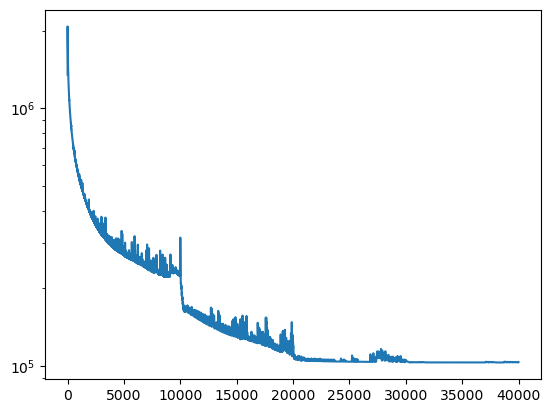

In [322]:
plt.semilogy(np.arange(len(loss)), loss)

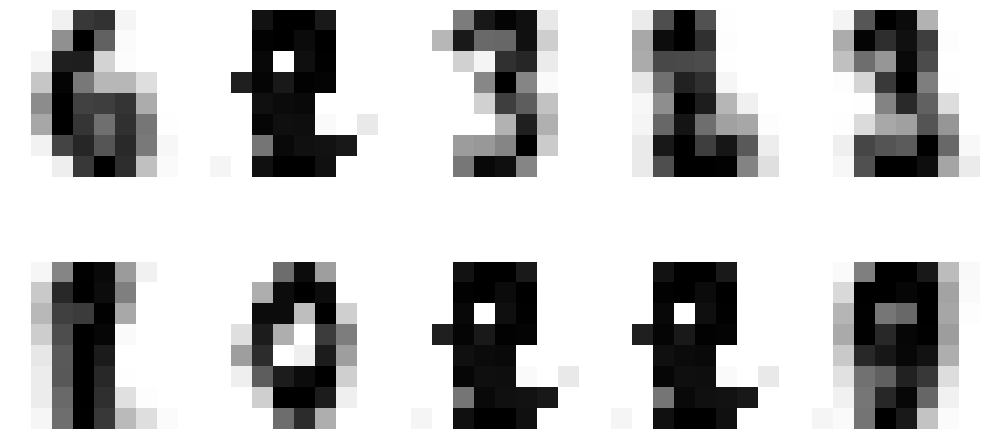

In [323]:
phi_1st_layer = params['poisson_layer']['phi']
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
for ax, phi in zip(axes.flatten(), phi_1st_layer):
    ax.set_axis_off()
    image = phi.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

In [73]:
params

{'cap_layer': {'c': Array([0.22094342, 0.5927665 , 0.8509286 , ..., 0.13017495, 0.15428396,
         0.27587804], dtype=float32),
  'r': Array([0.09900001, 0.01043126, 0.09900001, 0.46361232, 0.00138916,
         0.09900001, 0.09900001, 0.01669618, 0.09900001, 0.09900001],      dtype=float32),
  'theta': Array([[0.09900001, 0.09900001, 0.09900001, ..., 0.09900001, 0.09900001,
          0.09900001],
         [0.09900001, 0.09900001, 0.09900001, ..., 0.3205768 , 0.09900001,
          0.09900001],
         [0.09900001, 0.09900001, 0.09900001, ..., 0.09900001, 0.09900001,
          0.09900001],
         ...,
         [0.09900001, 0.09900001, 0.09900001, ..., 0.09900001, 0.09900001,
          0.09900001],
         [0.09900001, 0.09900001, 0.09900001, ..., 0.09900001, 0.09900001,
          0.09900001],
         [0.09900001, 0.09900001, 0.09900001, ..., 0.09900001, 0.09900001,
          0.09900001]], dtype=float32)},
 'poisson_layer': {'phi': Array([[ 1.21328514e-03,  1.68022439e-02,  3.46920